# Setup

In [2]:
include("../lna.jl")
using DifferentialEquations, StatsBase, Plots, Distributions, LaTeXStrings, DataFrames, CSV, ProgressBars, Optim


function reaction(n)
    "
    ρ_m$(n), 0 --> M$(n)
    δ_m$(n), M$(n) --> 0
    σ_b$(n), M$(n) + R --> MR$(n)
    δ_u$(n), MR$(n) --> M$(n) + R
    ρ_p$(n), MR$(n) --> M$(n) + P$(n) + R
    δ_mr$(n), MR$(n) --> 0
    δ_p$(n), P$(n) --> 0
    "
end

function endstring(n)
    cumulative_string = "end ρ_r δ_r "
    for i in 1:n
        cumulative_string = string(cumulative_string, "ρ_m$(i) δ_m$(i) σ_b$(i) δ_u$(i) ρ_p$(i) δ_mr$(i) δ_p$(i) ")
    end
    cumulative_string
end

function generate_rn(n)
    rnstring = "rn = @reaction_network begin
        ρ_r, 0 --> R
        δ_r, R --> 0
    "
    for i in 1:n
        rnstring = string(rnstring, reaction(i))
    end
    rnstring = string(rnstring, endstring(n))
    rnexpression = Base.Meta.parse(rnstring)
    eval(rnexpression)
end

function generate_propensities(n)
    rand(Float64, (6*n+2))
end

function relative_error(true_val, approx_val)
    map(abs, 1 .- approx_val./true_val)
end

# Valid always
function FF_single_gene_ribosome(props)
    k1 = props[3]
    k2 = props[4]
    k3 = props[5] - props[6] + props[7] # What should this really be?
    k6 = props[2]
    k7 = props[1]
    return 1 + k3*k7/(k6*(k2+k6))+k1*k3/(2*k2*k6)
end

# Valid if k2>>k6
function FF_single_gene_ribosome_approx(props)
    k1 = props[3]
    k2 = props[4]
    k3 = props[5]/props[6] + props[7]/ props[8] # What should this really be?
    k6 = props[2]
    k7 = props[1]
    return 1 + k3*k7/(k6*k2)+k1*k3/(2*k2*k6)
end

function FF_single_gene_ribosome_sim(props, p)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7)
    return 1 + k3*k7/(k6*(k2+k6))+k1*k3/(2*k2*k6)
end

# Valid if k2>>k6
function FF_single_gene_ribosome_approx_sim(props, p)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7)
    return 1 + k3*k7/(k6*k2)+k1*k3/(2*k2*k6)
end

function FF_can_approx_sim(props, p, r)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7) * r
    return 1 + k3*k7/(k2*k6)
end

function FF_can(means, covs)
    covs[2,2]/means[2]
end

function FF_rib(means, covs)
    covs[3,3]/means[3]
end

function FF_rib_bound(means, covs)
    covs[3,3]/means[3]
end

function FF_rib_bound_int(means, covs)
    covs[4,4]/means[4]
end

function FF_wc(means, covs)
    covs[4,4]/means[4]
end

function rn_can_f()
    return @reaction_network begin
        k1, 0 --> m
        k2, m --> 0
        k3, m --> m + p
        k6, p --> 0
    end k1 k2 k3 k6
end

function rn_rib_f()
    return @reaction_network begin
        k1, 0 --> r
        k2, r --> 0
        k3, 0 --> m
        k4, m --> 0
        k5, m + r --> m + r + p
        k6, p --> 0
    end k1 k2 k3 k4 k5 k6
end

function rn_rib_bound_f()
    return @reaction_network begin
        k1, 0 --> r
        k2, r --> 0
        k3, 0 --> m
        k4, m --> 0
        k5, m + r --> m + r + p
        k6, p --> 0
        k7, r --> rb
        k8, rb --> r
        k9, rb --> 0
    end k1 k2 k3 k4 k5 k6 k7 k8 k9
end

function rn_rib_bound_int_f()
    return @reaction_network begin
        k1, 0 --> r
        k2, r --> 0
        k3, 0 --> m
        k4, m --> 0
        k5, m + r --> rs
        k6, rs --> m + r
        k7, rs --> m + r + p
        k8, p --> 0
        k9, rs --> 0 
        k10, r --> rb
        k11, rb --> r
        k12, rb --> 0
    end k1 k2 k3 k4 k5 k6 k7 k8 k9 k10 k11 k12
end

function ps_can_f(ps, lnameans_bound) # ps frmo rib_bound
    return [
        ps[3],
        ps[4],
        ps[5]*lnameans_bound[1],
        ps[2]
    ]
end

function ps_rib_bound_f(ps, lnameans_bound_int) # ps from rib bound int
    
    k2 = ps[4] + (ps[5]*ps[2]/(ps[6]+ps[7]+ps[2]))*lnameans_bound_int[1]
    kb = (ps[2]+ps[11]) * (ps[5] / (ps[6] + ps[7] + ps[2])*lnameans_bound_int[2] + ps[10]/(ps[11] + ps[2]))
    return [
        ps[1], # rib creation
        ps[2], # rib degredation
        ps[3], # mrna creation
        k2, # mrna degredation
        ps[5]*ps[7]/(ps[6]+ps[7]+ps[2]), # translation
        ps[2], # protein degredation = rib degredation
        kb, # rib binding
        ps[11], # rib unbinding
        ps[2], # bound ribosome degredation
    ]
end

function ps_rib_bound_int_f(ps, lnameans) # ps from whole cell
    k3_values = ps[5+7:7:length(ps)]
    k4_values = ps[6+7:7:length(ps)]
    k5_values= ps[7+7:7:length(ps)]
    k6 = ps[2]
    m_values = lnameans[2+3:3:length(lnameans)]
    sigma = sum((k3_values .- ((k4_values .+ k5_values) .* k3_values) ./ (k4_values .+ k5_values .+ k6)) .* m_values)
    
    rib_unbinding = 100
    rib_binding = sigma *(rib_unbinding + k6)/k6 
    return [
        ps[1], # rib creation
        ps[2], # rib degredation
        ps[3], # mrna creation
        ps[4], # mrna degredation
        ps[5],# rib binding
        ps[6],# rib unbinding
        ps[7], # translation
        ps[2], # protein degredation = rib degredation
        ps[2], # monosome degredation
        rib_binding, # rib binding
        rib_unbinding, # rib unbinding
        ps[2], # bound ribosome degredation
    ]
end

function negative_binomial_ys(xs, mean, var)
    p = mean/var
    r = var*p^2/(1-p)

    nb = NegativeBinomial(r,p)
    return Distributions.pdf(nb, xs)
end

negative_binomial_ys (generic function with 1 method)

# Verifying the LNA solution

In [22]:
N = 10

rn = generate_rn(N)

ps = [50., .1]
    
for i in 1:N
    ps = vcat(ps, [1.5, .1, .2, .1, .5, .1, .1])
end

prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 5000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)

protein_counts = map(x -> x[4], sol.u)

LoadError: InterruptException:

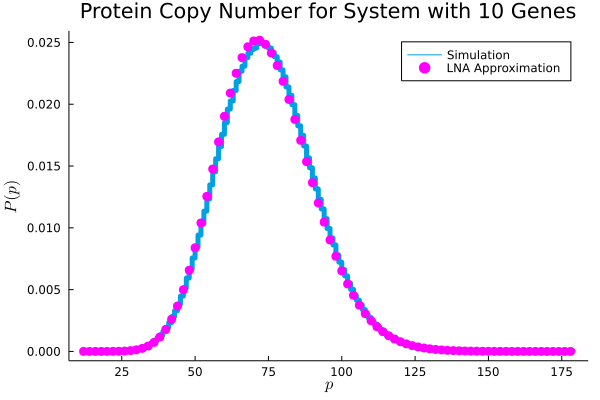

In [3]:
histogram(protein_counts, nbins=maximum(protein_counts), norm=true, label="Stochastic Simulation Algorithm")

prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

step=2
nb = NegativeBinomial(r,p)
xs = [minimum(protein_counts):step:maximum(protein_counts)]
ys = Distributions.pdf(nb, xs)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    title = "Protein Copy Number for System with $N Genes", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    markersize=5,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [4]:
savefig("../../data/figures-for-paper/protein_copy_number_$(N)_genes.svg")

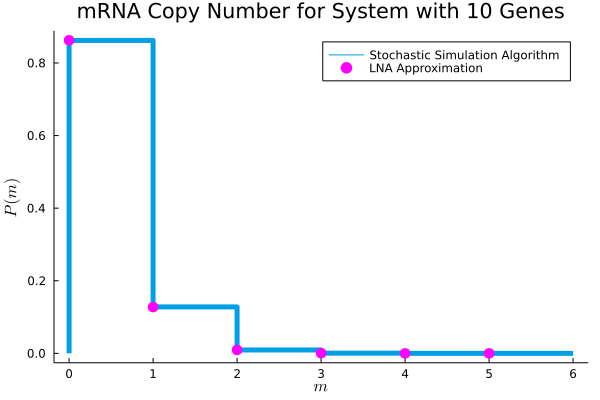

In [5]:
mrna_counts = map(x -> x[2], sol.u)
histogram(mrna_counts, 
    nbins=maximum(mrna_counts), 
    norm=true, 
    label="Stochastic Simulation Algorithm",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

m_mean = lnameans[2]
m_var = lnacovs[2,2]

p = m_mean/m_var
r = m_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
xs = [0:1:maximum(mrna_counts)]
ys = Distributions.pdf(nb, xs)
scatter!(
    xs,
    ys,
    label="LNA Approximation", 
    title = "mRNA Copy Number for System with $(N) Genes",
    xlabel=L"m",
    ylabel=L"P(m)",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [6]:
savefig("../../data/figures-for-paper/mrna_copy_number_$(N)_genes.svg")

# Matching models at the mean level.

In [2]:
N = 10
ps = [N*10*10*log(2)/1200., log(2)/1200.] # [ribosome production, ribosome degredation]
for j in 1:N
    ps = vcat(
        ps, 
        [
            rand(Normal(log(2)/210*5, 0.1*log(2)/210*5)), # mRNA creation
            rand(Normal(log(2)/210 + log(2)/1200, 0.1*log(2)/210 + log(2)/1200)), # mRNA degredation
            rand(Normal(.0001, 0.1*.0001)), # binding to polysome
            rand(Normal(0.0001, 0.00001)), # unbinding from polysome
            rand(Normal(0.1,0.01)), # translation,
            log(2)/1200, # monosome decay
            log(2)/1200 # protein decay
        ]
    )
end

rn = generate_rn(10)

prob = LNAProblem(rn, zeros(Int, length(species(rn))), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)


31×31 Matrix{Float64}:
 966.434     -0.240744     -0.183648     …   -0.974816       236.154
  -0.240744   3.01573      -0.000287414      -0.000189782     -0.157197
  -0.183648  -0.000287414   2.68045          -0.00289686       0.516746
 158.961     38.2997       34.2877            0.623753        85.5714
  -0.958148   0.00126525   -0.00151545       -0.00153026      -0.677879
  -0.981826  -0.00023816   -0.00295879   …   -0.00846915       0.878715
 292.816     -0.195659      0.640071          1.07055        152.129
  -0.690952   0.000996357  -0.0010126        -0.000920287     -0.473602
  -0.615219  -0.00034123   -0.00202539       -0.00636448       0.849321
 278.954     -0.175693      0.620095          1.05972        148.187
  -0.296262   0.00049105   -0.000371813  …   -0.000267408     -0.195113
  -0.237423  -0.000295732  -0.000928214      -0.00335117       0.567934
 178.215     -0.106978      0.40125           0.696013        95.8396
   ⋮                                     ⋱            

In [3]:
rn_bound_int = rn_rib_bound_int_f()
prob = LNAProblem(rn_bound_int, zeros(Int, length(species(rn_bound_int))), ps_rib_bound_int_f(ps, lnameans))

sol = solve(prob)

lnameans_bound_int = mean(sol)
lnacovs_bound_int = StatsBase.cov(sol)

5×5 Matrix{Float64}:
 956.41       -0.230649     -0.202733      155.832     0.0168222
  -0.230649    3.01572      -0.000271427    38.301    -0.00996299
  -0.202733   -0.000271427   2.68041        34.28     -0.00875772
 155.832      38.301        34.28         5893.74      6.73159
   0.0168222  -0.00996299   -0.00875772      6.73159  41.299

In [4]:
lnameans_bound_int

u: 5-element Vector{Float64}:
 956.0205375342564
   3.015315204299181
   2.6812174677687364
 427.53974600785824
  41.29824499805791

Check that the means of the mRNA, protein and ribosome copy numbers are all identical.

In [5]:
free_rib_rel_err = relative_error(lnameans[1], lnameans_bound_int[1])
monosome_rel_err = relative_error(lnameans[3], lnameans_bound_int[3])
mrna_rel_err = relative_error(lnameans[2], lnameans_bound_int[2])
protein_rel_err = relative_error(lnameans[4], lnameans_bound_int[4])
bound_rib_rel_err = relative_error(sum(lnameans[6:3:length(species(rn))]), lnameans_bound_int[5])

print("""
    free ribosome error: $(free_rib_rel_err)
    mrna error: $(mrna_rel_err)
    monosome error: $(monosome_rel_err)
    protein error: $(protein_rel_err)
    bound ribosome error: $(bound_rib_rel_err)
    """)

free ribosome error: 8.282263763703668e-14
mrna error: 4.551914400963142e-15
monosome error: 6.772360450213455e-14
protein error: 6.772360450213455e-14
bound ribosome error: 9.14823772291129e-14


In [6]:
rn_bound = rn_rib_bound_f()
prob = LNAProblem(rn_bound, zeros(Int, length(species(rn_bound))), ps_rib_bound_f(ps_rib_bound_int_f(ps, lnameans), lnameans_bound_int))

sol = solve(prob)

lnameans_bound = mean(sol)
lnacovs_bound = StatsBase.cov(sol)

4×4 Matrix{Float64}:
 956.021       0.0       204.368    -7.1574e-8
   0.0         3.01532    41.6815    0.0
 204.368      41.6815   6428.93      9.40143
  -7.1574e-8   0.0         9.40143  43.9795

In [7]:
free_rib_rel_err = relative_error(lnameans_bound_int[1], lnameans_bound[1])
mrna_rel_err = relative_error(lnameans_bound_int[2], lnameans_bound[2])
protein_rel_err = relative_error(lnameans_bound_int[4], lnameans_bound[3])

print("""
    free ribosome error: $(free_rib_rel_err)
    mrna error: $(mrna_rel_err)
    protein error: $(protein_rel_err)
    """)

free ribosome error: 3.404023507513898e-9
mrna error: 2.220446049250313e-15
protein error: 1.8780597077494576e-9


In [8]:
rn_can = rn_can_f()
prob = LNAProblem(rn_can, zeros(Int, length(species(rn_can))), ps_can_f(ps_rib_bound_f(ps_rib_bound_int_f(ps, lnameans), lnameans_bound_int), lnameans_bound))

sol = solve(prob)

lnameans_can = mean(sol)
lnacovs_can = StatsBase.cov(sol)

2×2 Matrix{Float64}:
  3.01532    41.6815
 41.6815   6337.53

In [9]:
mrna_rel_err = relative_error(lnameans_bound[2], lnameans_can[1])
protein_rel_err = relative_error(lnameans_bound[3], lnameans_can[2])

print("""
    mrna error: $(mrna_rel_err)
    protein error: $(protein_rel_err)
    """)

mrna error: 2.1274426664774637e-11
protein error: 1.5046976997723505e-9


## Fitting to synthetic data

In [13]:
initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 100000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)

protein_counts = map(x -> x[4], sol.u)

100000001-element Vector{Int64}:
 428
 429
 431
 431
 431
 430
 429
 429
 428
 427
 428
 428
 428
   ⋮
 465
 465
 465
 464
 464
 464
 464
 464
 466
 466
 466
 466

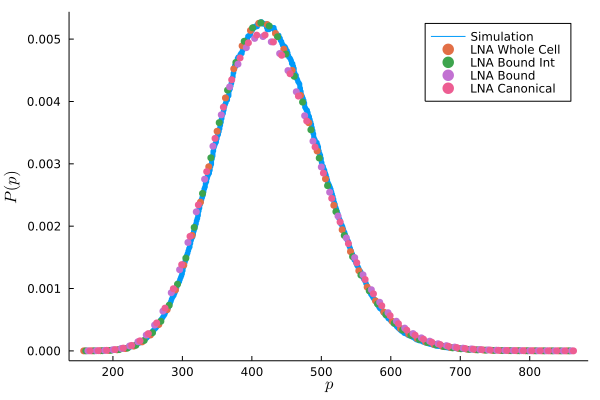

In [14]:
prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 12
xs = collect(minimum(protein_counts):step:maximum(protein_counts))

histogram(
    protein_counts, 
    nbins=maximum(protein_counts) - minimum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color = palette(:default)[1],
)

scatter!(
    xs,
    negative_binomial_ys(xs, lnameans[4], lnacovs[4,4]), 
    label="LNA Whole Cell", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = palette(:default)[2],
    markerstrokecolor=palette(:default)[2],
    grid=false,
    markersize=4
)

scatter!(
    xs .+ 3,
    negative_binomial_ys(xs .+ 3, lnameans_bound_int[4], lnacovs_bound_int[4,4]), 
    label="LNA Bound Int", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = palette(:default)[3],
    markerstrokecolor=palette(:default)[3],
    grid=false,
    markersize=4
)

scatter!(
    xs .+ 6,
    negative_binomial_ys(xs .+ 6, lnameans_bound[3], lnacovs_bound[3,3]), 
    label="LNA Bound", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = palette(:default)[4],
    markerstrokecolor=palette(:default)[4],
    grid=false,
    markersize=4
)

scatter!(
    xs .+ 9,
    negative_binomial_ys(xs .+ 9, lnameans_can[2], lnacovs_can[2,2]), 
    label="LNA Canonical", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = palette(:default)[7],
    markerstrokecolor=palette(:default)[7],
    grid=false,
    markersize=4
)

In [15]:
savefig("../../data/figures-for-paper/Comparison-of-distributions-with-matching-means-10-genes.svg")

# Comparison of Full and Reduced Models

In [9]:
xs = 1:10:100
ffs_full = zeros(length(xs))
ffs_red = zeros(length(xs))
ffs_red_approx = zeros(length(xs))

for i in 1:length(xs)
    N = xs[i]
    rn = generate_rn(N)

    ps = [50., .1]

    for j in 1:N
        ps = vcat(ps, [1.5, .1, .2, .1, .5, .1, .1])
    end

    prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

    sol = solve(prob)

    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)

    ffs_full[i] = lnacovs[4,4]/lnameans[4]
    ffs_red[i] = FF_single_gene_ribosome_sim(ps, lnameans[4])
    ffs_red_approx[i] = FF_single_gene_ribosome_approx_sim(ps, lnameans[4])
end

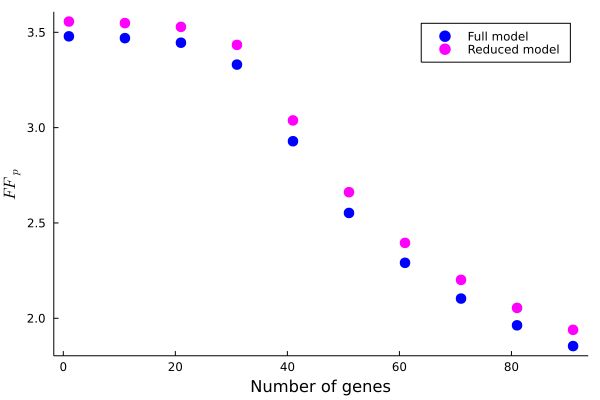

In [10]:
scatter(
    xs,
    ffs_full,
    label="Full model",
    markersize=6,
    markercolor=RGBA(0/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(0/255, 0/255, 255/255, 255/255),
)

scatter!(
    xs,
    ffs_red,
    label="Reduced model",
    xlabel="Number of genes",
    ylabel=L"FF_{p}",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false)

In [11]:
savefig("../../data/figures-for-paper/full_model_verses_reduced_model_$(N)_genes.svg")

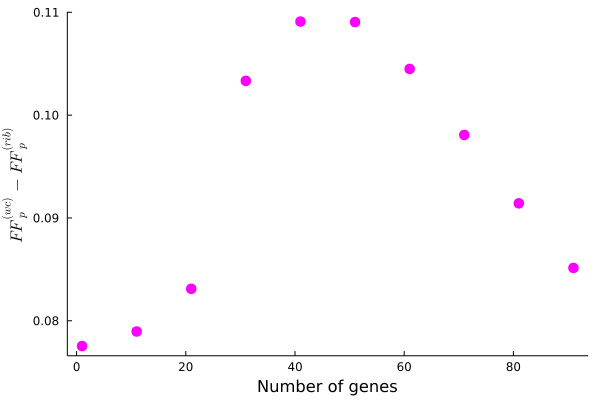

In [12]:
scatter(
    xs,
    ffs_red-ffs_full,
    ylabel=L"FF_p^{(wc)} - FF_p^{(rib)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [13]:
savefig("../../data/figures-for-paper/residuals_full_model_ribosome_model_$(N)_genes.svg")

# Choosing Realistic Parameters

In [14]:
# Load data from schwannhauser
exp_data = DataFrame(CSV.File("../../data/experimental_data_sanitised.csv"))
dropmissing!(exp_data)
names(exp_data)

7-element Vector{String}:
 "id"
 "pNumber"
 "mNumber"
 "alpha"
 "beta"
 "mHalfLife"
 "pHalfLife"

In [15]:
median(exp_data[!, :pNumber])

41913.32

In [16]:
mean(exp_data[!, :pNumber])

475168.0025453261

In [17]:
sort(exp_data, [:pNumber])[50, :]

DataFrameRow
 Row │ id             pNumber  mNumber  alpha    beta     mHalfLife  pHalfLife ⋯
     │ String         Float64  Float64  Float64  Float64  Float64    Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
  50 │ IPI00136246.1   343.98    17.43      2.0     1.57       8.54      39.97 ⋯

In [18]:
N = 10

rn = generate_rn(N)

ps = [50., .1]
    
for i in 1:N
    ps = vcat(
        ps, 
        [
            1.9, # mRNA creation
            log(2)/8.54, # mRNA degredation
            .01, # binding to polysome
            0.001, # unbinding from polysome
            5.0, # translation,
            .1, # monosome decay
            .1 # protein decay
        ]
    )
end


prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 10000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)
mrna_counts = map(x -> x[2], sol.u)
monosome_counts = map(x -> x[3], sol.u)
protein_counts = map(x -> x[4], sol.u)
ribosome_counts = map(x -> x[1], sol.u)

print("
    mRNA counts: $(mean(mrna_counts + monosome_counts))\n
    unbound mRNA counts: $(mean(mrna_counts))\n
    protein counts: $(mean(protein_counts))\n
    ribosomes counts: $(mean(ribosome_counts))\n
    ")


    mRNA counts: 21.226460977353902

    unbound mRNA counts: 11.822989717701029

    protein counts: 470.1744210825579

    ribosomes counts: 406.0090840990916

    

In [19]:
mean(mrna_counts + monosome_counts)

21.226460977353902

In [20]:
mean(mrna_counts)

11.822989717701029

In [21]:
mean(protein_counts)

470.1744210825579

In [22]:
mean(ribosome_counts)

406.0090840990916

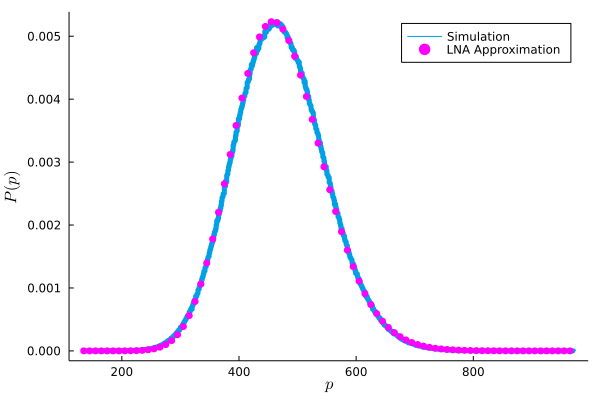

In [23]:
prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 10
xs = [minimum(protein_counts):step:maximum(protein_counts)]
ys = Distributions.pdf(nb, xs)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [24]:
savefig("../../data/figures-for-paper/protein_count_$(N)_genes_IPI00136246.svg")

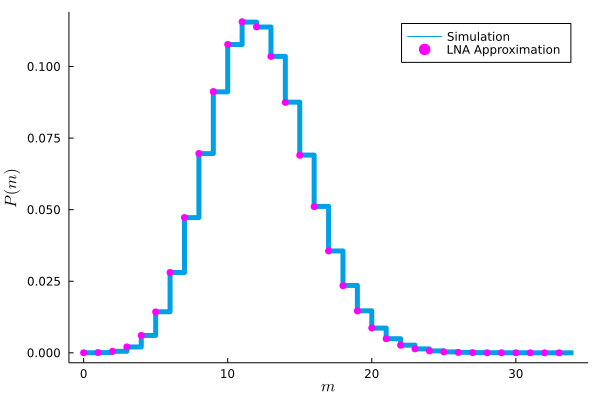

In [25]:
mrna_mean = lnameans[2]
mrna_var = lnacovs[2,2]

p = mrna_mean/mrna_var
r = mrna_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 1
xs = [minimum(mrna_counts):step:maximum(mrna_counts)]
ys = Distributions.pdf(nb, xs)


histogram(
    mrna_counts, 
    nbins=maximum(mrna_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"m", 
    ylabel=L"P(m)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [26]:
savefig("../../data/figures-for-paper/mrna_count_$(N)_genes_IPI00136246.svg")

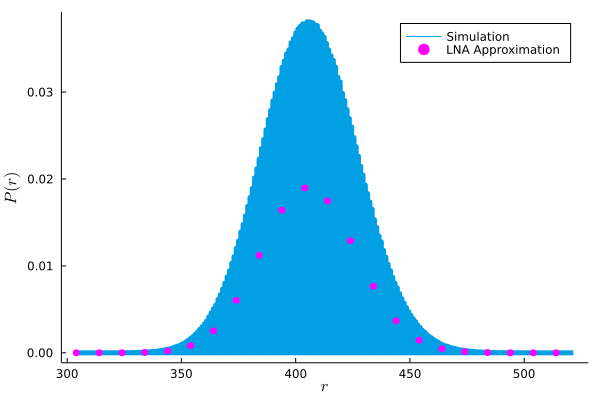

In [27]:
rib_counts = ribosome_counts
rib_mean = lnameans[1]
rib_var = lnacovs[1,1]

p = rib_mean/rib_var
r = rib_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 10
xs = [minimum(rib_counts):step:maximum(rib_counts)]
ys = Distributions.pdf(nb, xs)


histogram(
    rib_counts, 
    nbins=400, 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"r", 
    ylabel=L"P(r)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [28]:
savefig("../../data/figures-for-paper/rib_count_$(N)_genes_IPI00136246.svg")

# Comparing Differences for Large Number of Genes

The first idea here is to use the IPI00136246 gene and have N perturbed copies. The total number of ribosomes will need to be much larger than the number of proteins.

In [29]:
N = 151
xs = 1:10:N
ffs_full = zeros(length(xs))
ffs_red = zeros(length(xs))
ffs_red_approx = zeros(length(xs))

p_mean_full = zeros(length(xs))
p_mean_red = zeros(length(xs))

for i in ProgressBar(1:length(xs))
    N = xs[i]
    rn = generate_rn(N)

    
    ps = [50., .1]
    for i in ProgressBar(1:N)
        ps = vcat(
            ps, 
            [
                1.9, # mRNA creation
                log(2)/8.54, # mRNA degredation
                .01, # binding to polysome
                0.001, # unbinding from polysome
                5.0, # translation,
                .1, # monosome decay
                .1 # protein decay
            ]
        )
        flush(stdout)
    end


    prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

    sol = solve(prob)

    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    

    ffs_full[i] = lnacovs[4,4]/lnameans[4]
    ffs_red[i] = FF_single_gene_ribosome_sim(ps, lnameans[4])
    ffs_red_approx[i] = FF_single_gene_ribosome_approx_sim(ps, lnameans[4])
    
    p_mean_full[i] = lnameans[4]
end

0.0%┣                                               ┫ 0/16 [00:00<00:-1, -0s/it]
0.0%┣                                                ┫ 0/1 [00:00<00:00, -0s/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, InfGs/it]
6.2%┣██▊                                        ┫ 1/16 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                               ┫ 0/11 [00:00<00:-1, -0s/it]
9.1%┣████                                       ┫ 1/11 [00:00<Inf:Inf, InfGs/it]
100.0%┣███████████████████████████████████████████┫ 11/11 [00:00<00:00, 199it/s]
12.5%┣█████▉                                         ┫ 2/16 [00:01<00:07, 2it/s]
0.0%┣                                               ┫ 0/21 [00:00<00:-1, -0s/it]
4.8%┣██                                         ┫ 1/21 [00:00<Inf:Inf, InfGs/it]
100.0%┣███████████████████████████████████████████┫ 21/21 [00:00<00:00, 398it/s]
18.8%┣████████▉             

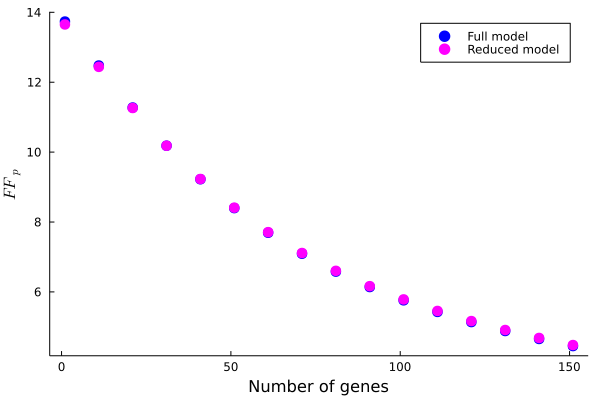

In [30]:
scatter(
    xs,
    ffs_full,
    label="Full model",
    markersize=6,
    markercolor=RGBA(0/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(0/255, 0/255, 255/255, 255/255),
)

scatter!(
    xs,
    ffs_red,
    label="Reduced model",
    xlabel="Number of genes",
    ylabel=L"FF_{p}",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [31]:
savefig("../../data/figures-for-paper/fano_factor_$(N)_copies_gene_IPI00136246.svg")

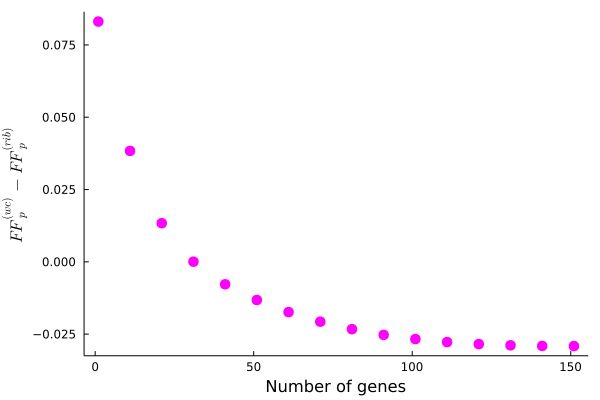

In [32]:
scatter(
    xs,
    ffs_full-ffs_red,
    ylabel=L"FF_p^{(wc)} - FF_p^{(rib)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [33]:
savefig("../../data/figures-for-paper/fano_factor_difference_$(N)_copies_gene_IPI00136246.svg")

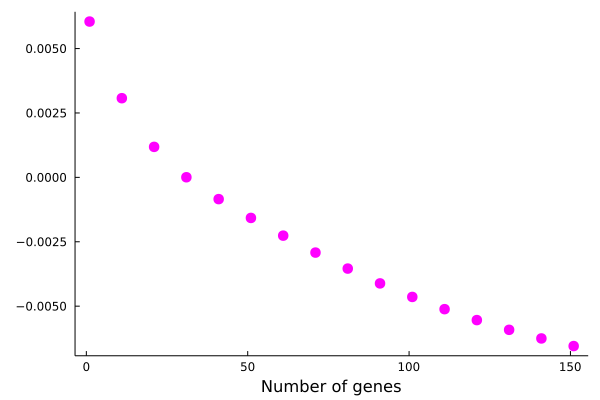

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


In [34]:
scatter(
    xs,
    (ffs_full .- ffs_red) ./ ffs_full,
    ylabel=L"\left(FF_p^{(wc)} - FF_p^{(rib)\right)/FF_p^{(wc)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [35]:
savefig("../../data/figures-for-paper/fano_factor_rel_error_$(N)_copies_gene_IPI00136246.svg")

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


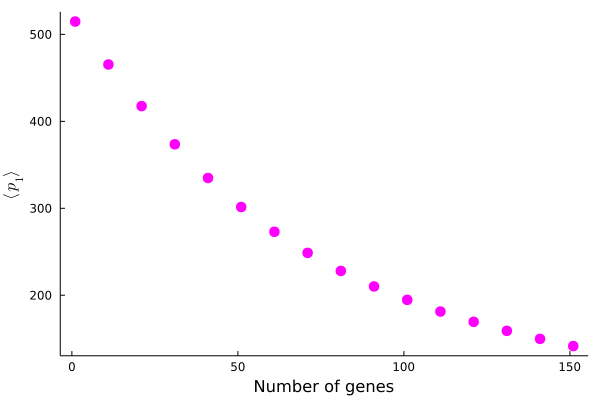

In [36]:
scatter(
    xs,
    p_mean_full,
    ylabel=L"\langle p_1 \rangle",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [37]:
savefig("../../data/figures-for-paper/protein_copy_number_$(N)_copies_gene_IPI00136246.svg")

This assumes that the rate parameters are "real" variables which are independent of the number of genes. In reality the single gene model should have different inferred parameters which produce the same measured quantities, ie the gene number and decay rate. Since the decay rate is measurable we can keep those variables the same and only have to infer the protein constants.

## Keeping ribosome-gene ratio constant

In [38]:
N = 61
xs = 1:10:N
ffs_full = zeros(length(xs))
ffs_red = zeros(length(xs))
ffs_red_approx = zeros(length(xs))

p_mean_full = zeros(length(xs))
p_mean_red = zeros(length(xs))

for i in ProgressBar(1:length(xs))
    N = xs[i]
    rn = generate_rn(N)

    
    ps = [50. * N, .1]
    for j in 1:N
        ps = vcat(
            ps, 
            [
                1.9, # mRNA creation
                log(2)/8.54, # mRNA degredation
                .01, # binding to polysome
                0.001, # unbinding from polysome
                5.0, # translation,
                .1, # monosome decay
                .1 # protein decay
            ]
        )
    end


    prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

    sol = solve(prob)

    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    

    ffs_full[i] = lnacovs[4,4]/lnameans[4]
    ffs_red[i] = FF_single_gene_ribosome_sim(ps, lnameans[4])
    ffs_red_approx[i] = FF_single_gene_ribosome_approx_sim(ps, lnameans[4])
    
    p_mean_full[i] = lnameans[4]
end

0.0%┣                                                ┫ 0/7 [00:00<00:00, -0s/it]
14.3%┣██████▏                                    ┫ 1/7 [00:00<Inf:Inf, InfGs/it]
28.6%┣█████████████▊                                  ┫ 2/7 [00:00<00:02, 3it/s]
42.9%┣████████████████████▋                           ┫ 3/7 [00:02<00:05, 1s/it]
57.1%┣███████████████████████████▍                    ┫ 4/7 [00:08<00:08, 3s/it]
71.4%┣██████████████████████████████████▎             ┫ 5/7 [00:20<00:10, 5s/it]
85.7%┣█████████████████████████████████████████▏      ┫ 6/7 [00:44<00:09, 9s/it]
100.0%┣██████████████████████████████████████████████┫ 7/7 [01:26<00:00, 14s/it]
100.0%┣██████████████████████████████████████████████┫ 7/7 [01:26<00:00, 14s/it]


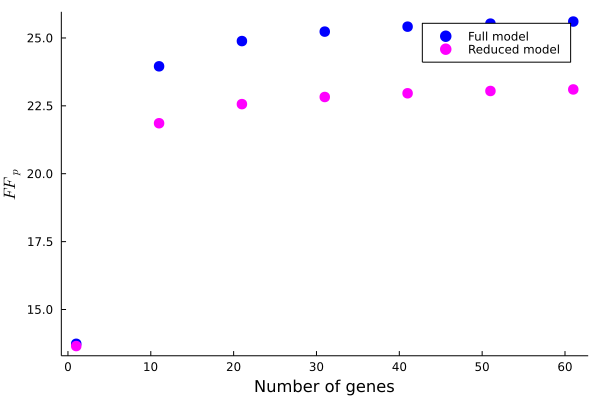

In [39]:
scatter(
    xs,
    ffs_full,
    label="Full model",
    markersize=6,
    markercolor=RGBA(0/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(0/255, 0/255, 255/255, 255/255),
)

scatter!(
    xs,
    ffs_red,
    label="Reduced model",
    xlabel="Number of genes",
    ylabel=L"FF_{p}",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [40]:
savefig("../../data/figures-for-paper/rib_const_fano_factor_$(N)_copies_gene_IPI00136246.svg")

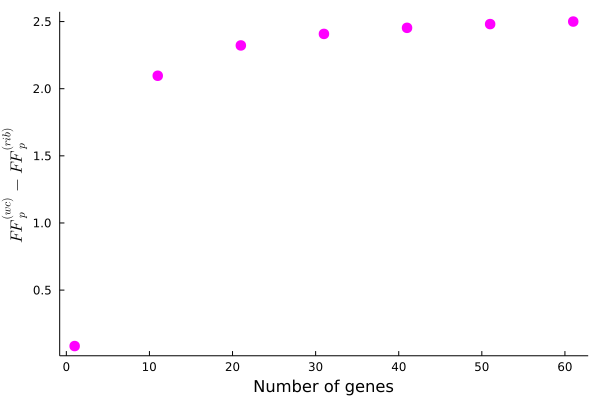

In [41]:
scatter(
    xs,
    ffs_full-ffs_red,
    ylabel=L"FF_p^{(wc)} - FF_p^{(rib)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [42]:
savefig("../../data/figures-for-paper/rib_const_fano_factor_residual_$(N)_copies_gene_IPI00136246.svg")

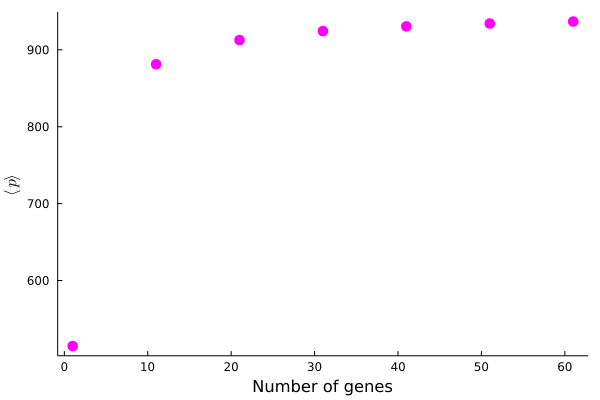

In [43]:
scatter(
    xs,
    p_mean_full,
    ylabel=L"\langle p \rangle",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [44]:
savefig("../../data/figures-for-paper/rib_const_protein_copy_number_$(N)_copies_gene_IPI00136246.svg")

# Using an array of different genes.

## Whole cell model

In [36]:
N = 10
rn = generate_rn(N)

ps = [N*10*10*log(2)/1200., log(2)/1200.] # [ribosome production, ribosome degredation]
for j in 1:N
    ps = vcat(
        ps, 
        [
            rand(Normal(log(2)/210*5, 0.1*log(2)/210*5)), # mRNA creation
            log(2)/1200. + rand(Normal(log(2)/210, 0.1*log(2)/210)), # mRNA degredation
            rand(Normal(.0001, 0.1*.0001)), # binding to polysome
            rand(Normal(0.0001, 0.00001)), # unbinding from polysome
            rand(Normal(0.1,0.01)), # translation,
            log(2)/1200., # monosome decay
            log(2)/1200. # protein decay
        ]
    )
end

In [37]:
prob = LNAProblem(rn, zeros(length(species(rn))), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 100000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)
mrna_counts = map(x -> x[2], sol.u)
monosome_counts = map(x -> x[3], sol.u)
protein_counts = map(x -> x[4], sol.u)
ribosome_counts = map(x -> x[1], sol.u)

100000001-element Vector{Int64}:
 964
 961
 964
 963
 965
 968
 971
 964
 961
 961
 956
 955
 957
   ⋮
 919
 920
 921
 919
 921
 921
 918
 920
 918
 918
 919
 918

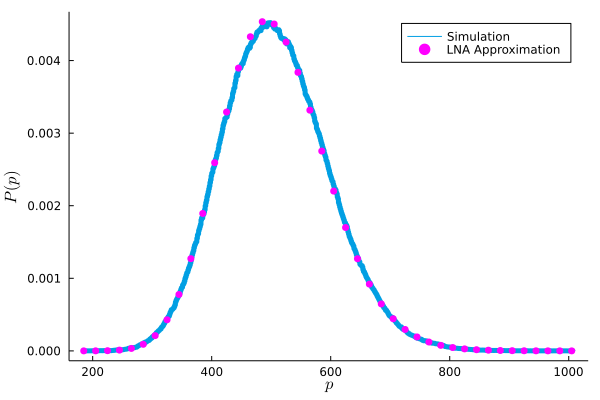

In [38]:
prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 20
xs_wc = [minimum(protein_counts):step:maximum(protein_counts)]
ys_wc = Distributions.pdf(nb, xs_wc)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs_wc,
    ys_wc, 
    label="LNA Approximation", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

## Reduced models

In [39]:
# rn bound int
rn_bound_int = rn_rib_bound_int_f()
prob = LNAProblem(rn_bound_int, zeros(Int, length(species(rn_bound_int))), ps_rib_bound_int_f(ps, lnameans))

sol = solve(prob)

lnameans_bound_int = mean(sol)
lnacovs_bound_int = StatsBase.cov(sol)

# rn bound
rn_bound = rn_rib_bound_f()
prob = LNAProblem(rn_bound, zeros(Int, length(species(rn_bound))), ps_rib_bound_f(ps_rib_bound_int_f(ps, lnameans), lnameans_bound_int))

sol = solve(prob)

lnameans_bound = mean(sol)
lnacovs_bound = StatsBase.cov(sol)

# rn canonical
rn_can = rn_can_f()
prob = LNAProblem(rn_can, zeros(Int, length(species(rn_can))), ps_can_f(ps_rib_bound_f(ps_rib_bound_int_f(ps, lnameans), lnameans_bound_int), lnameans_bound))

sol = solve(prob)

lnameans_can = mean(sol)
lnacovs_can = StatsBase.cov(sol)

2×2 Matrix{Float64}:
  3.12754    49.4942
 49.4942   8534.27

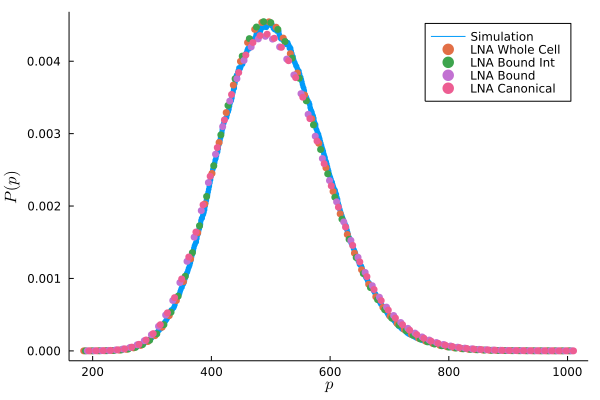

In [40]:
step = 12
xs = collect(minimum(protein_counts):step:maximum(protein_counts))

histogram(
    protein_counts, 
    nbins=maximum(protein_counts) - minimum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color = palette(:default)[1],
)

scatter!(
    xs,
    negative_binomial_ys(xs, lnameans[4], lnacovs[4,4]), 
    label="LNA Whole Cell", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = palette(:default)[2],
    markerstrokecolor=palette(:default)[2],
    grid=false,
    markersize=4
)

scatter!(
    xs .+ 3,
    negative_binomial_ys(xs .+ 3, lnameans_bound_int[4], lnacovs_bound_int[4,4]), 
    label="LNA Bound Int", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = palette(:default)[3],
    markerstrokecolor=palette(:default)[3],
    grid=false,
    markersize=4
)

scatter!(
    xs .+ 6,
    negative_binomial_ys(xs .+ 6, lnameans_bound[3], lnacovs_bound[3,3]), 
    label="LNA Bound", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = palette(:default)[4],
    markerstrokecolor=palette(:default)[4],
    grid=false,
    markersize=4
)

scatter!(
    xs .+ 9,
    negative_binomial_ys(xs .+ 9, lnameans_can[2], lnacovs_can[2,2]), 
    label="LNA Canonical", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = palette(:default)[7],
    markerstrokecolor=palette(:default)[7],
    grid=false,
    markersize=4
)

In [41]:
savefig("../../data/figures-for-paper/model_comparison_$(N)_genes_e_coli.svg")

In [43]:
ps_rib_bound = [
    ps[1], # rib creation
    ps[2], # rib degredation
    ps[3], # mrna creation
    ps[4], # mrna degredation
    ps[4]*ps[2]*ps[2]*lnameans[4]/(ps[3]*ps[1]), # translation
    ps[2], # protein degredation = rib degredation
    rib_binding, # rib binding
    rib_unbinding, # rib unbinding
    ps[2], # bound ribosome degredation
]

prob = LNAProblem(rn_rib_bound, zeros(Int, 4), ps_rib_bound)

sol = solve(prob)

lnameans_rib_bound = mean(sol)
lnacovs_rib_bound = StatsBase.cov(sol)

prot_mean = lnameans_rib_bound[3]
prot_var = lnacovs_rib_bound[3,3]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb_rib_bound = NegativeBinomial(r,p)
step = 20
xs_rib_bound = [minimum(protein_counts):step:maximum(protein_counts)]
ys_rib_bound = Distributions.pdf(nb_rib_bound, xs_rib_bound)

1-element Vector{Vector{Float64}}:
 [1.5073608756711104e-7, 9.269096314890701e-7, 4.3332971342135544e-6, 1.6096742486019895e-5, 4.916741194124824e-5, 0.00012688712830845667, 0.000282778049574258, 0.0005540062693972816, 0.0009683718135931271, 0.0015289758505146237  …  3.529185149459437e-5, 2.081147810424896e-5, 1.204606340641159e-5, 6.849724523792779e-6, 3.829426328522224e-6, 2.106449268908787e-6, 1.140848728758519e-6, 6.087638290484392e-7, 3.202430448216189e-7, 1.6617698631648634e-7]

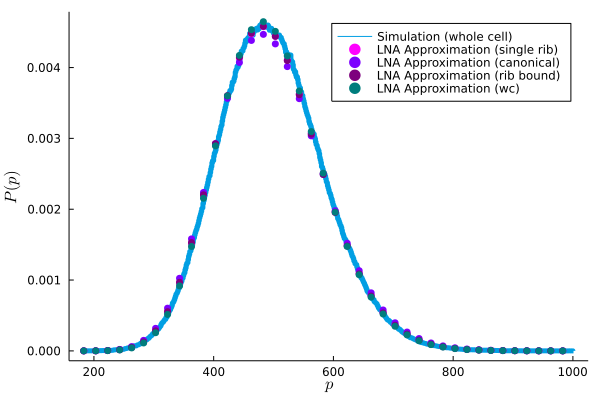

In [44]:
histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation (whole cell)",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs_rib,
    ys_rib, 
    label="LNA Approximation (single rib)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_can,
    ys_can, 
    label="LNA Approximation (canonical)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_rib_bound,
    ys_rib_bound, 
    label="LNA Approximation (rib bound)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 125/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 125/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_wc,
    ys_wc, 
    label="LNA Approximation (wc)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(0/255, 125/255, 125/255, 255/255),
    markerstrokecolor=RGBA(0/255, 125/255, 125/255, 255/255),
    grid=false,
    markersize=4
)

In [39]:
rn_rib = @reaction_network begin
    k1, 0 --> r
    k2, r --> 0
    k3, 0 --> m
    k4, m --> 0
    k5, m + r --> m + r + p
    k6, p --> 0
end k1 k2 k3 k4 k5 k6

Model ##ReactionSystem#309 with 6 equations
States (3):
  r(t)
  m(t)
  p(t)
Parameters (6):
  k1
  k2
  k3
  k4
  k5
  k6

In [40]:
ps_rib = [
    ps[1], # rib creation
    ps[2], # rib degredation
    ps[3], # mrna creation
    ps[4], # mrna degredation
    ps[4]*ps[2]*ps[2]*lnameans[4]/(ps[3]*ps[1]), # translation
    ps[2], # protein degredation = rib degredation
]

prob = LNAProblem(rn_rib, zeros(Int, 3), ps_rib)

sol = solve(prob)

lnameans_rib = mean(sol)
lnacovs_rib = StatsBase.cov(sol)

prot_mean = lnameans_rib[3]
prot_var = lnacovs_rib[3,3]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb_rib = NegativeBinomial(r,p)
step = 20
xs_rib = [minimum(protein_counts):step:maximum(protein_counts)]
ys_rib = Distributions.pdf(nb_rib, xs_rib)

1-element Vector{Vector{Float64}}:
 [1.4773944340566818e-7, 9.096481859004972e-7, 4.258056043143564e-6, 1.5837540505500333e-5, 4.843774628176277e-5, 0.00012516444662270451, 0.0002792967897811099, 0.0005478879664863076, 0.0009589060408980008, 0.0015159726699891024  …  3.599277655732574e-5, 2.1252041527182693e-5, 1.2316851243692522e-5, 7.0126873841190265e-6, 3.925562659131098e-6, 2.1621012144480952e-6, 1.1724920339524712e-6, 6.264515660124294e-7, 3.299705545457341e-7, 1.7144435099919184e-7]

In [41]:
rn_rib_bound = @reaction_network begin
    k1, 0 --> r
    k2, r --> 0
    k3, 0 --> m
    k4, m --> 0
    k5, m + r --> m + r + p
    k6, p --> 0
    k7, r --> rb
    k8, rb --> r
    k9, rb --> 0
end k1 k2 k3 k4 k5 k6 k7 k8 k9

Model ##ReactionSystem#310 with 9 equations
States (4):
  r(t)
  m(t)
  p(t)
  rb(t)
Parameters (9):
  k1
  k2
  k3
  k4
  k5
  k6
⋮

In [42]:
indexes = 5+7:7:length(ps)
length(ps)
rib_binding = sum(getindex(ps, indexes))
rib_unbinding = sum(getindex(ps, indexes .+ 1)) + sum(getindex(ps, indexes .+ 2))

0.9263452022001095

In [34]:
rn_can = @reaction_network begin
    k1, 0 --> m
    k2, m --> 0
    k3, m --> m + p
    k6, p --> 0
end k1 k2 k3 k6

Model ##ReactionSystem#306 with 4 equations
States (2):
  m(t)
  p(t)
Parameters (4):
  k1
  k2
  k3
  k6

In [35]:
ps_can =[
    ps[3], # mRNA creation
    ps[4], # mRNA degredation
    ps[4]*ps[9]*lnameans[4]/ps[3], # translation,
    ps[9] # protein decay
]

4-element Vector{Float64}:
 0.01741957875417873
 0.004108756343473096
 0.07324541226133473
 0.0006254724561137905

In [36]:
prob = LNAProblem(rn_can, zeros(Int, 2), ps_can)

sol = solve(prob)

lnameans_can = mean(sol)
lnacovs_can = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans_can))

prob = DiscreteProblem(rn_can, initial_values, (0, 190000000.),  ps_can)
jump_prob = JumpProblem(rn_can, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)
mrna_counts_can = map(x -> x[1], sol.u)
protein_counts_can = map(x -> x[2], sol.u)

190000001-element Vector{Int64}:
 497
 498
 496
 496
 497
 497
 497
 498
 499
 500
 500
 500
 499
   ⋮
 485
 485
 487
 485
 484
 484
 484
 484
 481
 481
 481
 481

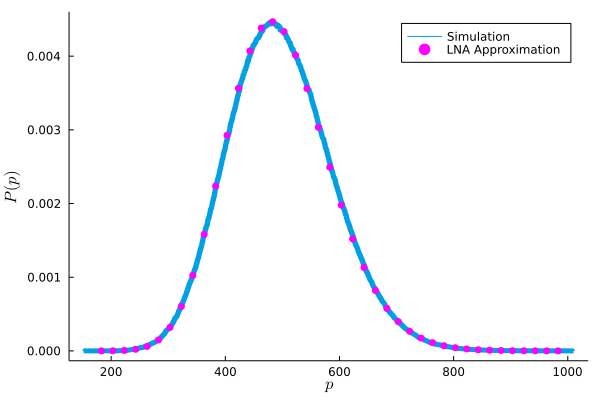

In [37]:
prot_mean = lnameans_can[2]
prot_var = lnacovs_can[2,2]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 20
xs_can = [minimum(protein_counts):step:maximum(protein_counts)]
ys_can = Distributions.pdf(nb, xs_can)

histogram(
    protein_counts_can, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs_can,
    ys_can, 
    label="LNA Approximation", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

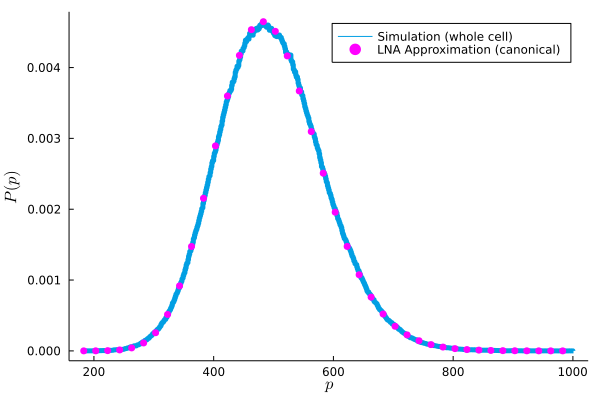

In [38]:
histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation (whole cell)",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs_wc,
    ys_wc, 
    label="LNA Approximation (canonical)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

# Error in Fano Factor against ribosome condition

In [45]:
N_samples = 1000
FFs_can = zeros(N_samples)
FFs_rib = zeros(N_samples)
FFs_rib_bound = zeros(N_samples)
FFs_rib_bound_int = zeros(N_samples)
FFs_wc = zeros(N_samples)
rib_conditions = zeros(N_samples)

for i in 1:N_samples
    N = 10
    ps = [N*10*10*log(2)/1200., log(2)/1200.] # [ribosome production, ribosome degredation]
    for j in 1:N
        ps = vcat(
            ps, 
            [
                rand(Normal(log(2)/210*5, 0.1*log(2)/210*5)), # mRNA creation
                log(2)/1200. + rand(Normal(log(2)/210, 0.1*log(2)/210)), # mRNA degredation
                rand(Normal(.0001, 0.1*.0001)), # binding to polysome
                rand(Normal(0.0001, 0.00001)), # unbinding from polysome
                rand(Normal(0.1,0.01)), # translation,
                log(2)/1200., # monosome decay
                log(2)/1200. # protein decay
            ]
        )
    end

    rn = generate_rn(N)
    prob = LNAProblem(rn, ones(Int, length(species(rn))) ./2, ps)
    sol = solve(prob)
    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    
    if minimum(lnameans) <= 0
        print("negative value")
        continue
    end

    rn_rib_bound_int = rn_rib_bound_int_f()
    ps_rib_bound_int = ps_rib_bound_int_f(ps, lnameans)
    prob = LNAProblem(rn_rib_bound_int, ones(Int, length(species(rn_rib_bound_int))) ./2, ps_rib_bound_int)
    sol = solve(prob)
    lnameans_rib_bound_int = mean(sol)
    lnacovs_rib_bound_int = StatsBase.cov(sol)

    rn_rib_bound = rn_rib_bound_f()
    ps_rib_bound = ps_rib_bound_f(ps_rib_bound_int, lnameans_rib_bound_int)
    prob = LNAProblem(rn_rib_bound, ones(Int, length(species(rn_rib_bound))) ./2, ps_rib_bound_f(ps, lnameans))
    sol = solve(prob)
    lnameans_rib_bound = mean(sol)
    lnacovs_rib_bound = StatsBase.cov(sol)
    
    rn_can = rn_can_f()
    ps_can = ps_can_f(ps_rib_bound, lnameans_can)
    prob = LNAProblem(rn_can, ones(Int, length(species(rn_can))) ./2, ps_can)
    sol = solve(prob)
    lnameans_can = mean(sol)
    lnacovs_can = StatsBase.cov(sol)
    
    FFs_can[i] = FF_can(lnameans_can, lnacovs_can)
    FFs_rib_bound[i] = FF_rib_bound(lnameans_rib_bound, lnacovs_rib_bound)
    FFs_rib_bound_int[i] = FF_rib_bound_int(lnameans_rib_bound_int, lnacovs_rib_bound_int)
    FFs_wc[i] = FF_wc(lnameans, lnacovs)
    
    rib_species_index = 3:3:length(species(rn))
    rib_conditions[i] = lnameans[3] /(lnameans[1] + sum(lnameans[rib_species_index]))
end

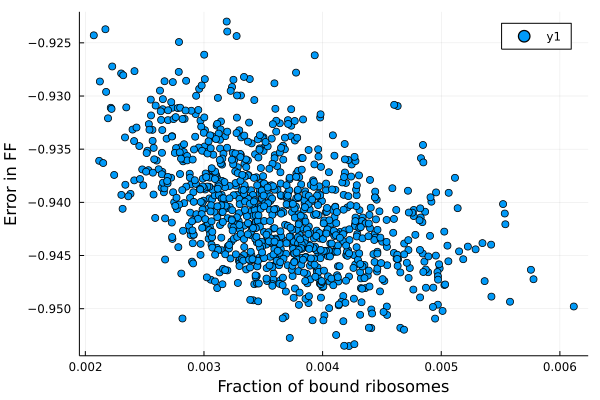

In [46]:
scatter(rib_conditions, (FFs_can - FFs_wc) ./ FFs_wc, ylabel="Error in FF", xlabel = "Fraction of bound ribosomes")

In [47]:
N_samples = 1000
FFs_can = zeros(N_samples)
FFs_rib = zeros(N_samples)
FFs_rib_bound = zeros(N_samples)
FFs_rib_bound_int = zeros(N_samples)
FFs_wc = zeros(N_samples)
rib_conditions = zeros(N_samples)

for i in 1:N_samples
    N = 10
    decay_const = rand()
    ps = [rand(), decay_const] # [ribosome production, ribosome degredation]
    for j in 1:N
        ps = vcat(
            ps, 
            [
                rand(), # mRNA creation
                decay_const + rand(), # mRNA degredation
                rand(), # binding to polysome
                rand(), # unbinding from polysome
                rand(), # translation,
                decay_const, # monosome decay
                decay_const # protein decay
            ]
        )
    end

    rn = generate_rn(N)
    prob = LNAProblem(rn, ones(Int, length(species(rn))) ./2, ps)
    sol = solve(prob)
    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    if minimum(lnameans) <= 0
        print("negative value")
        continue
    end
    
    rn_rib_bound_int = rn_rib_bound_int_f()
    ps_rib_bound_int = ps_rib_bound_int_f(ps, lnameans)
    prob = LNAProblem(rn_rib_bound_int, ones(Int, length(species(rn_rib_bound_int))) ./2, ps_rib_bound_int)
    sol = solve(prob)
    lnameans_rib_bound_int = mean(sol)
    lnacovs_rib_bound_int = StatsBase.cov(sol)

    rn_rib_bound = rn_rib_bound_f()
    ps_rib_bound = ps_rib_bound_f(ps_rib_bound_int, lnameans_rib_bound_int)
    prob = LNAProblem(rn_rib_bound, ones(Int, length(species(rn_rib_bound))) ./2, ps_rib_bound_f(ps, lnameans))
    sol = solve(prob)
    lnameans_rib_bound = mean(sol)
    lnacovs_rib_bound = StatsBase.cov(sol)
    
    rn_can = rn_can_f()
    ps_can = ps_can_f(ps_rib_bound, lnameans_can)
    prob = LNAProblem(rn_can, ones(Int, length(species(rn_can))) ./2, ps_can)
    sol = solve(prob)
    lnameans_can = mean(sol)
    lnacovs_can = StatsBase.cov(sol)
    
    FFs_can[i] = FF_can(lnameans_can, lnacovs_can)
    FFs_rib_bound[i] = FF_rib_bound(lnameans_rib_bound, lnacovs_rib_bound)
    FFs_rib_bound_int[i] = FF_rib_bound_int(lnameans_rib_bound_int, lnacovs_rib_bound_int)
    FFs_wc[i] = FF_wc(lnameans, lnacovs)
    
    rib_species_index = 3:3:length(species(rn))
    rib_conditions[i] = lnameans[3] /(lnameans[1] + sum(lnameans[rib_species_index]))
end

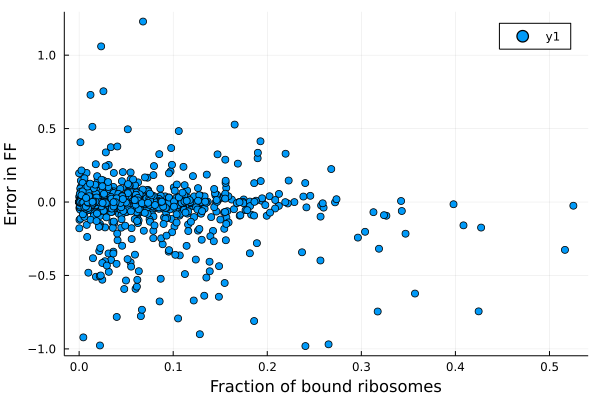

In [48]:
scatter(rib_conditions, (FFs_can - FFs_wc) ./ FFs_wc, ylabel="Error in FF", xlabel = "Fraction of bound ribosomes",
)

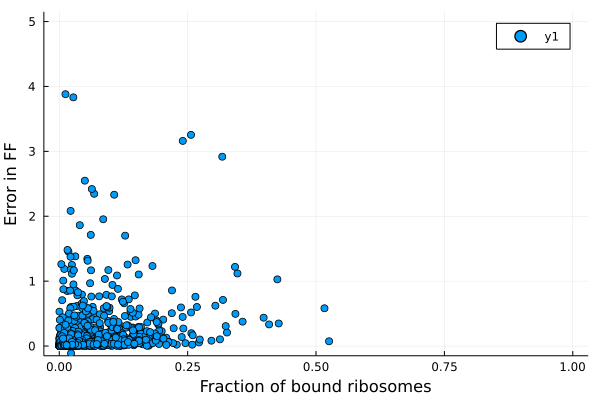

In [49]:
scatter(rib_conditions, (FFs_rib_bound - FFs_wc) ./ FFs_wc, ylabel="Error in FF", xlabel = "Fraction of bound ribosomes",
    xlims=[0,1.0],
    ylims=[0,5.0]
)

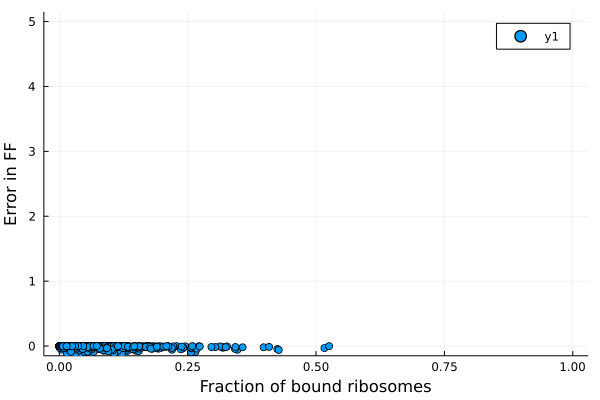

In [50]:
scatter(rib_conditions, (FFs_rib_bound_int - FFs_wc) ./ FFs_wc, ylabel="Error in FF", xlabel = "Fraction of bound ribosomes",
    xlims=[0,1.0],
    ylims=[0,5.0]
)

In [51]:
N_samples = 1000
FFs_can = zeros(N_samples)
FFs_rib = zeros(N_samples)
FFs_rib_bound = zeros(N_samples)
FFs_rib_bound_int = zeros(N_samples)
FFs_wc = zeros(N_samples)
rib_conditions = zeros(N_samples)

for i in 1:N_samples
    N = 10
    ps = [rand(), rand()] # [ribosome production, ribosome degredation]
    for j in 1:N
        ps = vcat(
            ps, 
            [
                rand(), # mRNA creation
                rand(), # mRNA degredation
                rand(), # binding to polysome
                rand(), # unbinding from polysome
                rand(), # translation,
                rand(), # monosome decay
                rand() # protein decay
            ]
        )
    end

    rn = generate_rn(N)
    prob = LNAProblem(rn, ones(Int, length(species(rn))) ./2, ps)
    sol = solve(prob)
    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    
    if minimum(lnameans) <= 0
        print("negative value")
        continue
    end
    
    rn_rib_bound_int = rn_rib_bound_int_f()
    ps_rib_bound_int = ps_rib_bound_int_f(ps, lnameans)
    prob = LNAProblem(rn_rib_bound_int, ones(Int, length(species(rn_rib_bound_int))) ./2, ps_rib_bound_int)
    sol = solve(prob)
    lnameans_rib_bound_int = mean(sol)
    lnacovs_rib_bound_int = StatsBase.cov(sol)

    rn_rib_bound = rn_rib_bound_f()
    ps_rib_bound = ps_rib_bound_f(ps_rib_bound_int, lnameans_rib_bound_int)
    prob = LNAProblem(rn_rib_bound, ones(Int, length(species(rn_rib_bound))) ./2, ps_rib_bound_f(ps, lnameans))
    sol = solve(prob)
    lnameans_rib_bound = mean(sol)
    lnacovs_rib_bound = StatsBase.cov(sol)
    
    rn_can = rn_can_f()
    ps_can = ps_can_f(ps_rib_bound, lnameans_can)
    prob = LNAProblem(rn_can, ones(Int, length(species(rn_can))) ./2, ps_can)
    sol = solve(prob)
    lnameans_can = mean(sol)
    lnacovs_can = StatsBase.cov(sol)
    
    FFs_can[i] = FF_can(lnameans_can, lnacovs_can)
    FFs_rib_bound[i] = FF_rib_bound(lnameans_rib_bound, lnacovs_rib_bound)
    FFs_rib_bound_int[i] = FF_rib_bound_int(lnameans_rib_bound_int, lnacovs_rib_bound_int)
    FFs_wc[i] = FF_wc(lnameans, lnacovs)
    
    rib_species_index = 3:3:length(species(rn))
    rib_conditions_across_mrna = zeros(length(rib_species_index))
    for k in 1:length(rib_species_index)
        rib_conditions_across_mrna[k] = lnameans[rib_species_index[k]] /(lnameans[1] + sum(lnameans[rib_species_index]))
    end
    rib_conditions[i] = maximum(rib_conditions_across_mrna)
end

negative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative value

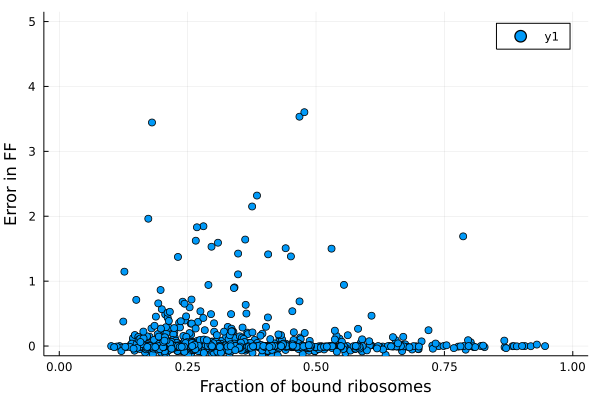

In [52]:
scatter(rib_conditions, (FFs_rib_bound_int - FFs_wc) ./ FFs_wc, ylabel="Error in FF", xlabel = "Fraction of bound ribosomes",
    xlims=[0,1.0],
    ylims=[0,5.0]
)

# Inferring parameters

## Canonical model

In [2]:
rn_can

LoadError: UndefVarError: rn_can not defined

In [3]:
ps = [120., 5., 3., 0.5]

rn_can = rn_can_f()

prob = LNAProblem(rn_can, zeros(length(species(rn_can))), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn_can, initial_values, (0, 50000.),  ps)

jump_prob = JumpProblem(rn_can, prob, Direct(), save_positions=(false, false))

# generate trajectories
N_experiments = 10
mrna_measurements = Vector{Vector{Int64}}(undef, 10)
protein_measurements = Vector{Vector{Int64}}(undef, 10)

for i in 1:N_experiments
    sol = solve(jump_prob, SSAStepper(), saveat=10.0)
    protein_counts = map(x -> x[2], sol.u)
    mrna_counts = map(x -> x[1], sol.u)
    mrna_measurements[i] = mrna_counts[2:maximum(mrna_counts)]
    protein_measurements[i] = protein_counts[2:maximum(protein_counts)]
end

plot(sol)

In [4]:
# For each trajectory we need to calculate a gaussian likelihood...
mu = mean(mrna_measurements[1])
sigma = std(mrna_measurements[1])

# To do in terms of model params rather than mu and sigma..

function log_likelihood_can(m_data, p_data, k1, k3, k6)
    k2 = 5.
    
    rn_can = rn_can_f()
    prob = LNAProblem(rn_can, zeros(length(species(rn_can))), [k1, k2, k3, k6])
    sol = solve(prob)
    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    
    norm_mrna = Normal(lnameans[1], sqrt(lnacovs[1,1]))
    norm_protein = Normal(lnameans[2], sqrt(lnacovs[2,2]))
    
    -sum(log.(pdf(norm_mrna, m_data))) - sum(log.(pdf(norm_protein, p_data)))
end

log_likelihood_can (generic function with 1 method)

In [5]:
lower = [0.1,0.1,0.1]
upper = [200, 200, 200]

x = optimize(x -> log_likelihood_can(mrna_measurements[1], protein_measurements[1], x[1], x[2], x[3]), lower, upper, [100., 1., 1.])

 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     9.459110e+02

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 4.74e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.00e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.39e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   66  (vs limit Inf)
    Iterations:    16
    f(x) calls:    17063
    ∇f(x) calls:   17063


In [6]:
Optim.minimizer(x)

3-element Vector{Float64}:
 118.44047658007771
   3.1857376545642824
   0.5287053721269399

## Rib bound model

In [7]:
rn_rib_bound_f()

Model ##ReactionSystem#293 with 9 equations
States (4):
  r(t)
  m(t)
  p(t)
  rb(t)
Parameters (9):
  k1
  k2
  k3
  k4
  k5
  k6
⋮

In [39]:
ps = [120., 0.5, 3.0, 0.7, 2.0, 0.5, 5.0, 1.0, 0.5]

rn_bound = rn_rib_bound_f()

prob = LNAProblem(rn_bound, zeros(length(species(rn_bound))), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn_bound, initial_values, (0, 5000.),  ps)

jump_prob = JumpProblem(rn_bound, prob, Direct(), save_positions=(false, false))


sol = solve(jump_prob, SSAStepper(), saveat=10.0)

rib_counts = map(x -> x[1], sol.u)
protein_counts = map(x -> x[3], sol.u)
mrna_counts = map(x -> x[2], sol.u)
rib_bound_counts = map(x -> x[4], sol.u)

50001-element Vector{Int64}:
 185
 183
 188
 186
 198
 197
 205
 176
 200
 184
 162
 188
 190
   ⋮
 186
 184
 193
 169
 178
 186
 174
 208
 192
 180
 212
 198

In [49]:
function log_likelihood_rib_bound(r_data, m_data, p_data, rib_bound_data, k7, k1, k3, kb)
    k2 = 0.7
    k6 = 0.5
    kmb = 1.0
    
    rn_bound = rn_rib_bound_f()
    prob = LNAProblem(rn_bound, zeros(length(species(rn_bound))), [k7, k6, k1, k2, k3, k6, kb, kmb, k6])
    sol = solve(prob)
    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    
    norm_rib = Normal(lnameans[1], sqrt(lnacovs[1,1]))
    norm_rib_bound = Normal(lnameans[4], sqrt(lnacovs[4,4]))
    norm_mrna = Normal(lnameans[2], sqrt(lnacovs[2,2]))
    norm_protein = Normal(lnameans[3], sqrt(lnacovs[3,3]))
    
    -sum(log.(pdf(norm_mrna, m_data))) - sum(log.(pdf(norm_protein, p_data)))- sum(log.(pdf(norm_rib, r_data))) - sum(log.(pdf(norm_rib_bound, rib_bound_data)))
end

log_likelihood_rib_bound (generic function with 6 methods)

In [51]:
lower = [0.1, 0.1, 0.1, 0.1]
upper = [200, 200, 200, 200]

x = optimize(
    x -> log_likelihood_rib_bound(
        rib_counts,
        mrna_counts,
        protein_counts,
        rib_bound_counts,
        x[1],
        x[2],
        x[3],
        x[4]
    ), 
    lower, 
    upper, 
    [100., 10., 10., 10.]
)

 * Status: success

 * Candidate solution
    Final objective value:     8.363286e+05

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 3.34e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.78e-12 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.21e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    6
    f(x) calls:    145
    ∇f(x) calls:   145


In [52]:
Optim.minimizer(x)

4-element Vector{Float64}:
 119.97908901331212
   2.990971295545843
   2.0074808660727146
   4.9963444718783565

## Rib bound int model

In [3]:
species(rn_rib_bound_int_f())

5-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 r(t)
 m(t)
 rs(t)
 p(t)
 rb(t)

In [4]:
ps = [120., 0.5, 3.0, 0.7, 2.0, 0.1, 10.0, 0.5, 0.5, 5.0, 1.0, 0.5]

rn_bound_int = rn_rib_bound_int_f()

prob = LNAProblem(rn_bound_int, zeros(length(species(rn_bound_int))), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn_bound_int, initial_values, (0, 50000.),  ps)

jump_prob = JumpProblem(rn_bound_int, prob, Direct(), save_positions=(false, false))


sol = solve(jump_prob, SSAStepper(), saveat=10.0)

rib_counts = map(x -> x[1], sol.u)
mrna_counts = map(x -> x[2], sol.u)
rib_int_counts = map(x -> x[3], sol.u)
protein_counts = map(x -> x[4], sol.u)
rib_bound_counts = map(x -> x[5], sol.u)

5001-element Vector{Int64}:
 181
 188
 146
 184
 182
 169
 155
 200
 166
 170
 166
 177
 151
   ⋮
 218
 161
 156
 189
 186
 213
 185
 179
 185
 160
 188
 201

In [5]:
function log_likelihood_rib_bound_int(r_data, m_data, rib_int_data, p_data, rib_bound_data, k1, k7, k3, k5, kb)
    [120., 0.5, 3.0, 0.7, 2.0, 0.1, 10.0, 0.5, 0.5, 5.0, 1.0, 0.5]
    #k7 = 120.
    k2 = 0.7
    k6 = 0.5
    kmb = 1.0
    #k3 = 2.0
    k4 = 0.1
    #k5 = 10.0
    #kb = 5.0
    
    rn_bound_int = rn_rib_bound_int_f()
    prob = LNAProblem(rn_bound_int, zeros(length(species(rn_bound_int))), [k7, k6, k1, k2, k3, k4, k5, k6, k6, kb, kmb, k6])
    sol = solve(prob)
    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    
    norm_rib = Normal(lnameans[1], sqrt(lnacovs[1,1]))
    norm_mrna = Normal(lnameans[2], sqrt(lnacovs[2,2]))
    norm_rib_int = Normal(lnameans[3], sqrt(lnacovs[3,3]))
    norm_protein = Normal(lnameans[4], sqrt(lnacovs[4,4]))
    norm_rib_bound = Normal(lnameans[5], sqrt(lnacovs[5,5]))
    
    -sum(log.(pdf(norm_rib_int, rib_int_data)))-sum(log.(pdf(norm_mrna, m_data))) - sum(log.(pdf(norm_protein, p_data)))- 
    sum(log.(pdf(norm_rib, r_data))) - sum(log.(pdf(norm_rib_bound, rib_bound_data)))
end

log_likelihood_rib_bound_int (generic function with 1 method)

In [6]:
lower = [0.1, 0.1, 0.1, 0.1, 0.1]
upper = [200, 200, 200, 200, 200]

x = optimize(
    x -> log_likelihood_rib_bound_int(
        rib_counts,
        mrna_counts,
        rib_int_counts,
        protein_counts,
        rib_bound_counts,
        x[1],
        x[2],
        x[3],
        x[4],
        x[5]
    ), 
    lower, 
    upper, 
    [10., 100., 10., 10., 10.]
)

 * Status: success

 * Candidate solution
    Final objective value:     7.846243e+04

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 4.10e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.40e-11 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.71e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    6
    f(x) calls:    122
    ∇f(x) calls:   122


In [7]:
Optim.minimizer(x)

5-element Vector{Float64}:
   3.00137829900326
 120.03433426801635
   1.9986494396145111
  10.020232857738872
   5.011917054595004

## Whole cell model

In [10]:
species(rn)

31-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 R(t)
 M1(t)
 MR1(t)
 P1(t)
 M2(t)
 MR2(t)
 P2(t)
 M3(t)
 MR3(t)
 P3(t)
 M4(t)
 MR4(t)
 P4(t)
 ⋮
 M7(t)
 MR7(t)
 P7(t)
 M8(t)
 MR8(t)
 P8(t)
 M9(t)
 MR9(t)
 P9(t)
 M10(t)
 MR10(t)
 P10(t)

In [8]:
N_genes = 10
rn = generate_rn(N_genes)

ps = [N_genes*100., 0.5] # [ribosome production, ribosome degredation]
for j in 1:N_genes
    ps = vcat(
        ps, 
        [
            3, # mRNA creation
            0.7, # mRNA degredation
            1.0, # binding to polysome
            0.1, # unbinding from polysome
            10.0, # translation,
            0.5, # monosome decay
            0.5 # protein decay
        ]
    )
end



prob = LNAProblem(rn, zeros(length(species(rn))), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 5000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=10.0)

rib_counts = map(x -> x[1], sol.u)
mrna_counts = map(x -> x[2], sol.u)
rib_int_counts = map(x -> x[3], sol.u)
protein_counts = map(x -> x[4], sol.u)

501-element Vector{Int64}:
 120
 129
  88
 111
  68
  84
  97
 167
 110
  93
 166
  76
  99
   ⋮
 173
 119
  81
  77
 145
 100
 105
 125
 173
  91
 123
 157